# Text classification for Fake News Detection

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import re
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import sys #to print to file
import nltk
nltk.download('punkt')
from sklearn.metrics import classification_report


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [4]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    # return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    
    label=convert_label(data_line[1]) #label element: data_line[1] read from file
    text=data_line[2] #statement element: data_line[2] read from file
    return (label, text)

In [5]:

# Input: a string of one statement
def pre_process(text):
    # Sentence segmentation is already done as the sentences are provided as different rows
    # word tokenisation
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings by replacing the punctations by the string
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings by replacing the punctations by the string
    tokens = re.split(r"\s+",text) # with space as delimeter it split the spaced text
    # normalisation - only by lower casing for now
    tokens = [t.lower() for t in tokens]
    return tokens
  

# Question 2: Basic Feature Extraction (20 marks)

In [6]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    local_dict={}
    for i in tokens:
      if i in local_dict:
        local_dict[i]+=1 # Adding 1 to the value of key if key already present
      else:
        local_dict[i]=1 # Adding key-value(value as 1) pair to the dictionary
    for w in tokens:
          try:
            global_feature_dict[w] # Checks if the key is already present in the dictionary, do nothing
          
          except KeyError:   
            i = len(global_feature_dict) + 1  # If it is not present then we add 1 to the length of the dictioanry
                
            global_feature_dict[w] = i # Then assign the new length as the value to the new key

    # Hence the global dictionary has keys with their indexes
    # and local dictionary is a Bag of Words model per sentence 
    return local_dict

In [7]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('model', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [8]:
def cross_validate(dataset, folds):
    fold_size = int(len(dataset)/folds) + 1
    cv=np.array([])
    accuracy=[]
    precision=[]
    recall=[]
    f1=[]
    j=0

    for i in range(0,len(dataset),int(fold_size)):
        train_fold=dataset[0:i]+dataset[i+fold_size:]  #training data for current fold
        test_fold=dataset[i:i+fold_size]    #test data for current fold
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE

        classifier=train_classifier(train_fold)# sending training data to LinearSVC
        predict=predict_labels([x[0] for x in test_fold],classifier) #sending the classfier and the Bag of words of test fold
        if i ==7380: # Value of item start of last fold
          global_test.append([x[1] for x in test_fold]) #extracting label for the last test fold for Heatmap and confusion matrix in nect question
          global_predict.append(predict) #extracting predicted output fot the last fold for Heatmap and confusion matrix in nect question
          global_test_text.append([x[0] for x in test_fold]) # extracting the Bag of words of the last test to print to file in the next question
        accuracy.append(accuracy_score([x[1] for x in test_fold],predict)) #calculating accuracy using label of test fold and predicted labels
        precision.append(precision_score([x[1] for x in test_fold], predict, average='weighted')) #calculating precision using label of test fold and predicted labels
        recall.append(recall_score([x[1] for x in test_fold], predict, average='weighted')) #calculating recall using label of test fold and predicted labels
        f1.append(f1_score([x[1] for x in test_fold], predict, average='weighted')) #calculating f1 using label of test fold and predicted labels
        
    cv=[100*np.mean(accuracy),100*np.mean(precision),100*np.mean(recall),100*np.mean(f1)] #average*100 of all 10 folds for all 4 parameters
        
    return cv

In [9]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [10]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset
global_test=[]         # to store label of last fold
global_predict=[]      # to store prdiction for last fold
global_test_text=[]    # to store bag of words for last fold

# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)




# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
13560


In [11]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...


[56.88922263606872, 56.97247193999616, 56.88922263606872, 56.88818090199837]

# 4. Error Analysis (10 marks)

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds,labels=labels) # sending last fold's label, predicted label and the Real & Fake strings
    print(cm) # printing confusion matrix
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

[[307 172]
 [141 192]]


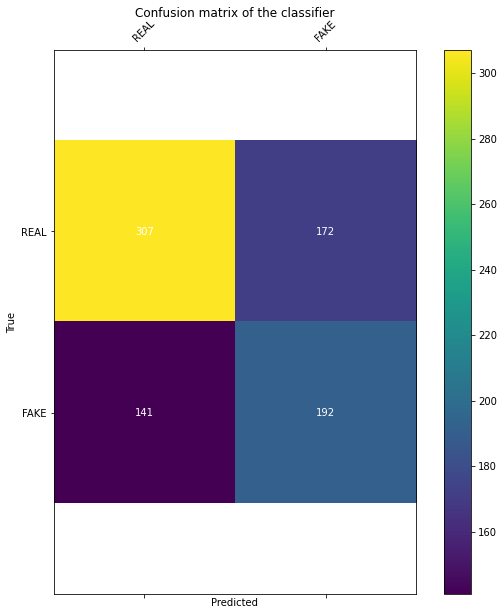

In [13]:
confusion_matrix_heatmap(global_test[0],global_predict[0],["REAL","FAKE"]) #Plotting confusion matrix on the last fold of data

In [ ]:
for i in range(0,len(global_predict[0])):
      if global_predict[0][i]=="REAL" and global_test[0][i]=="FAKE": # Predicted Real but is Fake, False Positive
        original_stdout = sys.stdout
        with open('False_Positive.rtf', 'a+') as f:
            f.seek(0) # Move read cursor to the start of file.
            data=f.read(100)  # If file is not empty then append '\n'
            if len(data) > 0 :
              f.write("\n")
            f.write(str(global_test_text[0][i])) # Append text at the end of file

In [ ]:
for i in range(0,len(global_predict[0])):
      if global_predict[0][i]=="FAKE" and global_test[0][i]=="REAL": # Predicted Fake but is Real, False Negative
        original_stdout = sys.stdout
        with open('False_Negative.rtf', 'a+') as f:
            f.seek(0) # Move read cursor to the start of file.
            data=f.read(100)  # If file is not empty then append '\n'
            if len(data) > 0 :
              f.write("\n")
            f.write(str(global_test_text[0][i])) # Append text at the end of file

# Questions 5 (20%) and 6 (20%) (recommend starting a new notebook)

In [ ]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = False  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])